## Load requisite packages

In [ ]:
# Check that GPU is enabled
!nvidia-smi

In [1]:
%%capture
import os

!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install transformers==4.52.4
#!pip install transformers==4.53.1
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
!pip install --no-deps unsloth

## Login to Hugging Face and WandB

In [2]:
# --- Hugging Face Login (for pushing the model) ---

from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
if hf_token:
    login(token=hf_token)
    print("Logged into Hugging Face.")
else:
    print("Warning: HF_TOKEN environment variable not set. Model pushing to Hugging Face might fail.")

Logged into Hugging Face.


### Login to WandB

In [3]:
import wandb

wb_token = user_secrets.get_secret("wb_token")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tuning Gemma-3-4B on Latex-OCR Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zattubiz (zattuonline) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load and Inspect the dataset

### About the data

The study uses a sampled dataset of handwritten math formulas. The objective is to convert these images into a LaTeX (a computer-readable format) for rendering. This is important for creating math-solving apps that enable students to photograph math problems for LLMs to solve. 

You can access the sampled dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR) and the full dataset [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).


### Load the dataset (for both train and test splits)

In [6]:
from datasets import load_dataset 
print("--- Loading LaTeX_OCR dataset ---")
train_dataset = load_dataset("unsloth/LaTeX_OCR", split="train")
test_dataset = load_dataset("unsloth/LaTeX_OCR", split="test")


--- Loading LaTeX_OCR dataset ---


README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

### Inspect the dataset

In [5]:
train_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [6]:
test_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 7632
})

### Check a sample image

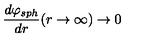

In [7]:
train_dataset[12]["image"]

### Check a corresponding LateX code

In [8]:
train_dataset[12]["text"]

'\\frac { d \\varphi _ { s p h } } { d r } ( r \\rightarrow \\infty ) \\rightarrow 0'

### Display the equation for the LateX

In [9]:
from IPython.display import display, Math, Latex

latex = train_dataset[12]["text"]
display(Math(latex))


<IPython.core.display.Math object>

## Prepare data before finetuning

### Convert training data into conversation format

In [10]:
# Prepare the training data in conversation format
instruction = "Write the LaTeX representation for this image."
def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}

converted_train_dataset = [convert_to_conversation(sample) for sample in train_dataset]

In [12]:
converted_train_dataset[12]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '\\frac { d \\varphi _ { s p h } } { d r } ( r \\rightarrow \\infty ) \\rightarrow 0'}]}]}

### Load the base model and processor

In [3]:
from IPython.display import display, Math, Latex
import torch
from unsloth import FastVisionModel, get_chat_template # Import necessary unsloth components
from datasets import load_dataset # Import load_dataset to get the dataset
from trl import SFTTrainer, SFTConfig # Import for fine-tuning
import difflib # Import difflib for sequence comparison

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-12 06:05:43.439391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752300343.650881      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752300343.714084      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [22]:
# This is the initial, pre-trained Gemma-3-4B model.
print("--- Loading base Gemma-3-4B model and processor ---")
model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

--- Loading base Gemma-3-4B model and processor ---
==((====))==  Unsloth 2025.7.3: Fast Gemma3 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


### Apply chat template to the processor

In [23]:
# Apply chat template to the processor for conversational formatting
processor = get_chat_template(
    processor,
    "gemma-3"
)

### Create a helper function to Generate LateX from image

In [15]:
# --- Helper Function: Generate LaTeX from an image ---
def generate_latex_from_image(model_to_use, processor_to_use, image, instruction):
    """
    Generates LaTeX representation for a given image using the provided model and processor.
    """
    messages = [
        {
            "role": "user",
            "content": [{"type": "image"}, {"type": "text", "text": instruction}],
        }
    ]

    input_text = processor_to_use.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor_to_use(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    output_ids = model_to_use.generate(
        **inputs,
        max_new_tokens=128,
        use_cache=True,
        temperature=1.0,
        top_p=0.95,
        top_k=64
    )

    generated_text_ids = output_ids[0, inputs["input_ids"].shape[1]:]
    generated_latex = processor_to_use.decode(generated_text_ids, skip_special_tokens=True)
    return generated_latex.replace("<end_of_turn>", "").strip()


### Create a helper function to evaluate the model

In [18]:
def calculate_latex_similarity(latex1, latex2):
    """
    Calculates a similarity ratio between two LaTeX strings using SequenceMatcher.
    Returns a float between 0.0 and 1.0.
    """
    return difflib.SequenceMatcher(None, latex1, latex2).ratio()

### Test the model before fine-tuning


Testing Model Performance BEFORE Fine-tuning

--- Test Example (Index 12) BEFORE Fine-tuning ---
Original LaTeX:
{ \partial } ^ { \mu } A _ { \mu } ^ { a b } = A ^ { \mu a c } B _ { \mu } ^ { c b } - B ^ { \mu a c } A _ { \mu } ^ { c b } ,


<IPython.core.display.Math object>

Generated LaTeX (Before Fine-tuning):
CDCl_(4) is a type of solvent.CDCl_4 (or CDCl_3 DCl_3 or CCl_3 Cl_3) is an organic solvent, also used as a solvent for NMR spectroscopy for various reasons.CDCl_4 is the abbreviation of deuterated chloroform.CDCl_4 is a tetramethylsilane substituted, non-protonated CCl_3 CI_3.CDCl_4 is also an organic compound, non-protonated tetrafluorotolene, a colorless, volatile, extremely flammable liquid that can be used as a solvent for a fluorocarbon. It is the main ingredient in


<IPython.core.display.Math object>

Similarity Score (Before Fine-tuning): 0.0033
Exact Match: NO (Expected before fine-tuning)

Original Image:


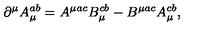

In [19]:
### Test the model before fine-tuning

# --- 3. Test the model BEFORE Fine-tuning ---
print("\n" + "="*50)
print("Testing Model Performance BEFORE Fine-tuning")
print("="*50)

# Set the base model to inference mode

FastVisionModel.for_inference(model)


# Choose a specific example from the test set to evaluate initial performance
test_example_index = 12 # You can change this index to test different examples
image_test_case = test_dataset[test_example_index]["image"]
original_latex_test_case = test_dataset[test_example_index]["text"]


print(f"\n--- Test Example (Index {test_example_index}) BEFORE Fine-tuning ---")

generated_latex_before_finetune = generate_latex_from_image(model, processor, image_test_case, instruction)

print("Original LaTeX:")
print(original_latex_test_case)
display(Math(original_latex_test_case))

print("Generated LaTeX (Before Fine-tuning):")
print(generated_latex_before_finetune)
display(Math(generated_latex_before_finetune))

similarity_before = calculate_latex_similarity(original_latex_test_case, generated_latex_before_finetune)
print(f"Similarity Score (Before Fine-tuning): {similarity_before:.4f}")

if generated_latex_before_finetune == original_latex_test_case:
    print("Exact Match: YES (Unlikely before fine-tuning)")
else:
    print("Exact Match: NO (Expected before fine-tuning)")

print("\nOriginal Image:")
display(image_test_case)

## Fine-tuning with Unsloth and LoRA

In [24]:
# --- 4. Fine-tuning with Unsloth and LoRA ---
print("\n\n" + "="*50)
print("Starting Fine-tuning Process with Unsloth and LoRA")
print("="*50)

# Add LoRA adapters to the model
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
    target_modules = "all-linear",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)



# Enable model for training
FastVisionModel.for_training(model)

# Configure and setup the SFTTrainer
from unsloth.trainer import UnslothVisionDataCollator # Import data collator

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_train_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,
        warmup_ratio = 0.03,
        max_steps = 30, # Keep steps low for demonstration, increase for full training
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 2,
        max_seq_length = 2048,
    )
)

# Start training
trainer_stats = trainer.train()
print("\nFine-tuning complete!")



Starting Fine-tuning Process with Unsloth and LoRA
Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients
Unsloth: Switching to float32 training since model cannot work with float16


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,2.452100
2,2.726500
3,2.716700
4,1.710200
5,1.448500
6,1.491100
7,1.100700
8,0.819900
9,0.579400
10,0.595700



Fine-tuning complete!


### See WandB metrics

In [25]:
# ---. Finish WandB run ---
if 'run' in locals() and run is not None:
    wandb.finish()

train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/grad_norm,▄▄▅▄▅█▆▄▃▃█▆█▆▃▂▁▂▂▁▁▁▁▅▁▂▂▂▁▂
train/learning_rate,▁█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
train/loss,▇██▅▄▅▃▃▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
total_flos,1963127618062464.0
train/epoch,0.00349
train/global_step,30
train/grad_norm,0.82985
train/learning_rate,0.0
train/loss,0.3154


### Test the model after Fine-tuning



Testing Model Performance AFTER Fine-tuning

--- Test Example (Index 12) AFTER Fine-tuning ---
Original LaTeX:
{ \partial } ^ { \mu } A _ { \mu } ^ { a b } = A ^ { \mu a c } B _ { \mu } ^ { c b } - B ^ { \mu a c } A _ { \mu } ^ { c b } ,


<IPython.core.display.Math object>

Generated LaTeX (After Fine-tuning):
\partial ^ { \mu } A ^ { a b } _ { \mu } = A ^ { \mu c } A _ { \mu } ^ { c b } - B _ { \mu } ^ { c b } A _ { \mu } ^ { c } ,


<IPython.core.display.Math object>

Similarity Score (After Fine-tuning): 0.5600
Exact Match: NO (May still occur, but similarity should be higher)

Original Image:


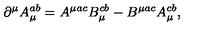

In [29]:
# Test the model AFTER Fine-tuning 
print("\n\n" + "="*50)
print("Testing Model Performance AFTER Fine-tuning")
print("="*50)

# Set the fine-tuned model back to inference mode
FastVisionModel.for_inference(model)

# Use the same test example as before to see the improvement
print(f"\n--- Test Example (Index {test_example_index}) AFTER Fine-tuning ---")
generated_latex_after_finetune = generate_latex_from_image(model, processor, image_test_case, instruction)

print("Original LaTeX:")
print(original_latex_test_case)
display(Math(original_latex_test_case))

print("Generated LaTeX (After Fine-tuning):")
print(generated_latex_after_finetune)
display(Math(generated_latex_after_finetune))

similarity_after = calculate_latex_similarity(original_latex_test_case, generated_latex_after_finetune)
print(f"Similarity Score (After Fine-tuning): {similarity_after:.4f}")

if generated_latex_after_finetune == original_latex_test_case:
    print("Exact Match: YES (Expected after fine-tuning)")
else:
    print("Exact Match: NO (May still occur, but similarity should be higher)")

print("\nOriginal Image:")
display(image_test_case)

### Evaluate Fine-tuned Model on Test Dataset

In [30]:
# --- NEW Helper Function: Evaluate Model on Dataset ---
def evaluate_model_on_dataset(model_to_eval, processor_to_eval, dataset_to_eval, instruction_text, num_examples=None):
    """
    Evaluates the model's performance on a given dataset by calculating average similarity.
    """
    print(f"\nEvaluating model on {len(dataset_to_eval) if num_examples is None else num_examples} examples...")
    total_similarity = 0
    exact_matches = 0
    examples_to_process = num_examples if num_examples is not None else len(dataset_to_eval)

    for i in range(min(examples_to_process, len(dataset_to_eval))):
        image = dataset_to_eval[i]["image"]
        original_latex = dataset_to_eval[i]["text"]
        generated_latex = generate_latex_from_image(model_to_eval, processor_to_eval, image, instruction_text)

        similarity = calculate_latex_similarity(original_latex, generated_latex)
        total_similarity += similarity

        if original_latex == generated_latex:
            exact_matches += 1

        # Optional: print individual results for debugging
        # print(f"Example {i+1}: Original='{original_latex[:50]}...', Generated='{generated_latex[:50]}...', Sim={similarity:.4f}")

    avg_similarity = total_similarity / examples_to_process
    exact_match_percentage = (exact_matches / examples_to_process) * 100

    print(f"\n--- Evaluation Results (on {examples_to_process} examples) ---")
    print(f"Average LaTeX Similarity: {avg_similarity:.4f}")
    print(f"Exact Match Percentage: {exact_match_percentage:.2f}%")
    return avg_similarity, exact_match_percentage

In [31]:
# Evaluate Fine-tuned Model on Test Dataset
print("\n\n" + "="*50)
print("Evaluating Fine-tuned Model on Test Dataset")
print("="*50)

# Set the fine-tuned model to inference mode (if not already)
FastVisionModel.for_inference(model)

# Evaluate on a subset of the test dataset for quicker demonstration
# For full evaluation, remove num_examples argument or set to len(test_dataset)
avg_sim_test, exact_match_test = evaluate_model_on_dataset(model, processor, test_dataset, instruction, num_examples=20)



Evaluating Fine-tuned Model on Test Dataset

Evaluating model on 20 examples...

--- Evaluation Results (on 20 examples) ---
Average LaTeX Similarity: 0.5313
Exact Match Percentage: 0.00%


## Push the model to Huggingface Hub

### Create a repo on Hugging face

In [ ]:
from huggingface_hub import HfApi

api = HfApi()


# Only create the repo once 
# api.create_repo(
#     repo_id="gemma3-4b-latex-ocr-finetuned-merged",  # Will use your logged-in username
#     repo_type="model"
# )

RepoUrl('https://huggingface.co/zattuAI/gemma3-4b-latex-ocr-finetuned-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='zattuAI/gemma3-4b-latex-ocr-finetuned-merged')

In [35]:
## Set the HF_REPO_ID

HF_REPO_ID = "zattuAI/gemma3-4b-latex-ocr-finetuned-merged"

### Push the model 

In [36]:
# --- Push the fine-tuned model to Hugging Face Hub (Merged Float16) ---
print("\n\n" + "="*50)
print(f"Pushing fine-tuned MERGED model to Hugging Face Hub: {HF_REPO_ID}")
print("="*50)

try:
    # Save the merged model (base model + LoRA weights) in float16 precision
    # This is ideal for deployment and general use by others.
    model.push_to_hub_merged(HF_REPO_ID, processor, token=hf_token) # Pass the token explicitly
    print("Merged model and processor successfully pushed to Hugging Face Hub!")
except Exception as e:
    print(f"Error pushing merged model to Hugging Face Hub: {e}")
    print("Please ensure your HF_TOKEN environment variable is set correctly and has write access to the repository.")
    print(f"Also, verify that the repository '{HF_REPO_ID}' exists or that you have permission to create it.")



Pushing fine-tuned MERGED model to Hugging Face Hub: zattuAI/gemma3-4b-latex-ocr-finetuned-merged


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [02:49<02:49, 169.63s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [05:02<00:00, 151.25s/it]


Merged model and processor successfully pushed to Hugging Face Hub!
